In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

### 1. Loading the Data Set

In [2]:
from sklearn.datasets import fetch_20newsgroups

train_set = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_set = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
X_train, y_train = train_set.data, train_set.target
X_test, y_test = test_set.data, test_set.target

### 2. Data Exploration

In [4]:
print('Documents in training set:', len(X_train))
print('Documents in test set:', len(X_test))

Documents in training set: 11314
Documents in test set: 7532


In [5]:
categories = train_set.target_names
categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
print(X_train[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [7]:
categories[y_train[0]]

'rec.autos'

### 3. Vectorizing the text

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)

In [9]:
print(X_train_vec.shape)

(11314, 101322)


In [10]:
vocab = vectorizer.get_feature_names_out()
print(vocab[50000:50010]) # pick a subset of the tokens

['innacurate' 'innappropriate' 'innards' 'innate' 'innately' 'inneficient'
 'inner' 'innermost' 'innertubes' 'innervation']


In [11]:
print(X_train_vec.nnz / X_train_vec.shape[0])

66.802987449178


In [12]:
X_test_vec = vectorizer.transform(X_test)

### 4. Building a Multinomial NB Classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.01)
clf.fit(X_train_vec, y_train)

MultinomialNB(alpha=0.01)

### 5. Evaluating the model

In [14]:
from sklearn.metrics import f1_score

accuracy_train = clf.score(X_train_vec, y_train)
y_train_pred = clf.predict(X_train_vec)
f1_train = f1_score(y_train, y_train_pred, average='macro')

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'F1 score (train): {f1_train:.4f}')

Accuracy (train): 0.9595
F1 score (train): 0.9622


In [15]:
accuracy_test = clf.score(X_test_vec, y_test)
y_test_pred = clf.predict(X_test_vec)
f1_test = f1_score(y_test, y_test_pred, average='macro')

print(f'Accuracy (test): {accuracy_test:.4f}')
print(f'F1 score (test): {f1_test:.4f}')

Accuracy (test): 0.7010
F1 score (test): 0.6844


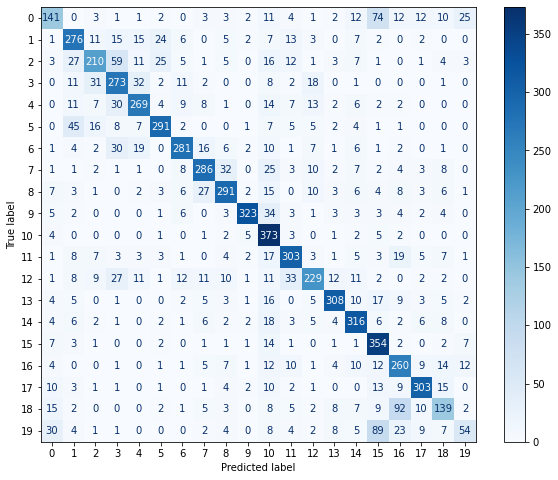

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')

plt.savefig('figures/confusion_matrix.pdf')

### 6. Benchmarking

In [17]:
import time

def benchmark(classifiers, names, X_train, y_train, X_test, y_test, verbose=True):
    evaluations = []
    
    for clf, name in zip(classifiers, names):
        evaluation = {}
        evaluation['classifier'] = name

        start_time = time.time()
        clf.fit(X_train, y_train)
        evaluation['training_time'] = time.time() - start_time

        evaluation['accuracy'] = clf.score(X_test, y_test)
        y_test_pred = clf.predict(X_test)
        evaluation['f1_score'] = f1_score(y_test, y_test_pred, average='macro')
        
        if verbose:
            print(evaluation)
        evaluations.append(evaluation)
    return evaluations

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

classifiers = [clf, LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
names = ['Multinomial NB', 'Logistic Regression', 'KNN', 'Random Forest', 'AdaBoost']

evaluations = benchmark(classifiers, names, X_train_vec, y_train, X_test_vec, y_test)

{'classifier': 'Multinomial NB', 'training_time': 0.06881546974182129, 'accuracy': 0.7010090281465746, 'f1_score': 0.6844389919212164}
{'classifier': 'Logistic Regression', 'training_time': 36.39215636253357, 'accuracy': 0.6909187466808284, 'f1_score': 0.6778246092753284}
{'classifier': 'KNN', 'training_time': 0.0059583187103271484, 'accuracy': 0.08218268720127456, 'f1_score': 0.07567337211476842}


In [ ]:
df = pd.DataFrame(evaluations).set_index('classifier')

df['accuracy'].plot.barh()
plt.xlabel('Accuracy (test)')
plt.ylabel('Classifier')
plt.savefig('figures/benchmark_accuracy.pdf', bbox_inches='tight')

In [ ]:
df['f1_score'].plot.barh(color='purple')
plt.xlabel('F1 score (test)')
plt.ylabel('Classifier')
plt.savefig('figures/benchmark_f1_score.pdf', bbox_inches='tight')

In [ ]:
df['training_time'].plot.barh(color='green')
plt.xlabel('Training time (sec)')
plt.ylabel('Classifier')
plt.savefig('figures/benchmark_training_time.pdf', bbox_inches='tight')

### 7. Find the Most Informative Features

In [ ]:
def show_top_n_features(clf, vectorizer, categories, n=10):
    feature_names = vectorizer.get_feature_names_out()
    
    for i, category in enumerate(categories):       
        top_n = np.argsort(clf.feature_log_prob_[i])[-n:]
        print(f"{category}: {' '.join(feature_names[top_n])}")

In [ ]:
show_top_n_features(clf, vectorizer, categories)